In [206]:
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras import models,layers

In [208]:
batch_size = 32      # modelin her seferinde 32 görüntü alıp eğitim yapması , verileri tek tek değil gruplar halinde alır
image_size = 256     # resimlerimiz 256x256
seed = 12            # random_state gibi aynı işlemi her calıstırdıgında aynı sonuc alması icin seed= 1213485 yazsan farketmez
epochs = 4           # veri kmesinin model tarafından ka. kez işeleneceği
channels = 3         # rgb

In [210]:
df = tf.keras.preprocessing.image_dataset_from_directory(  #lazy loading yaparak veriyi gerektiği anda okur ve işler bellegi verimli kullanır. pipeline yapısı sayesinde tel seferde tüm veriyi işleyebilirsin ön işleme , artırma,batching , karıştırma .
    "tomato",
    image_size=image_size,
    batch_size = batch_size,
    shuffle=True,
    seed=seed
)

Found 16011 files belonging to 10 classes.


In [211]:
class_names=df.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [212]:
for image_batch,image_label in df.take(1):    # İlk batch'i alır.   image_batch ilk batch içindeki görüntüler,image_label ilk batch içindeki etiketler
    print(image_batch.shape)   # 32 batch size 256 image size 3 ise rgb  Görüntülerin batch boyutunu ve boyutlarını (height, width, channel) gösterir
    print(image_label.numpy())  # 10 adet sınıfımız var

(32, 256, 256, 3)
[9 7 6 0 0 9 8 2 5 5 6 7 8 0 7 4 0 9 7 0 5 5 6 0 7 7 6 3 4 4 8 0]


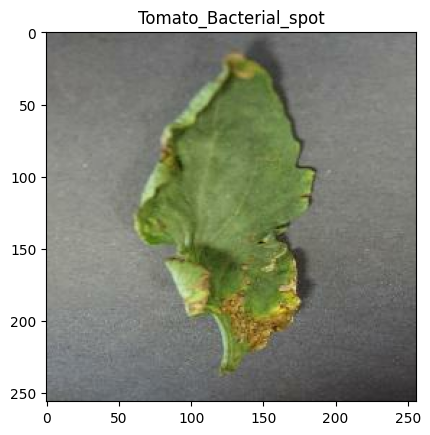

In [213]:
for image_batch,image_label in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))   # tensorflow tensorleri genellikle float türündedir.
    plt.title(class_names[image_label[0]])   # etiketler class_name listesiyle verildi
    plt.axis("off")

In [214]:
len(df)

501

In [215]:
train_size=0.8
len(df)*train_size

400.8

In [216]:
train_ds=df.take(400)

In [217]:
test_ds=df.skip(400)

In [218]:
val_size=0.1
len(df)*val_size

50.1

In [219]:
val_ds=test_ds.take(50)
len(val_ds)

50

In [220]:
test_ds=test_ds.skip(50)

In [221]:
len(test_ds)

51

In [222]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # cache -> önbellekleme. eeğer veri kümesi küçükse ram'a yükleyerek tekrar tekrar diskten okumayı önler. Büyük ise önbellek alma işlemi disküzerinde yapılır . veri okumayı hızlandırır
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)   # shuffle ->karıştırma. 1000 örn. rastgele karıştırır modelin sırasıyla aynı verileri öğrenmesini engeller overfitting önler.
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)   # prefetch -> ön yükleme. bir batch işlem görürken bir sonraki batch önbelleğe alınırç GPU/CPU nun boşta beklemesini önler. modeli hızlandırır.  AUTOTUNE -> tensorflowun en iyi önbellekleme miktarını otomatik secmesi

In [223]:
resize_and_rescaling = tf.keras.Sequential([
    tf.keras.layers.Resizing(image_size,image_size),  # resimler tekrar boyutlandırıldı standart hale getirildi 
    tf.keras.layers.Rescaling(1./255.) # piksel değerini 0-255 arasından 0-1 arasına# piksel değerini 0-255 arasından 0-1 arasına çevirdi. model çok büyük değerle çalışır ve eğitim verimsiz hale # #gelebilirdi yapılmasa.modeli hızlandırdı. çevirdi. model çok büyük değerle çalışır ve eğitim verimsiz hale # #gelebilirdi yapılmasa.modeli hızlandırdı.
])

In [224]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="HORIZONTAL_AND_VERTICAL"),
    tf.keras.layers.RandomRotation(0.2)
])

In [225]:
n_classes=10
input_shape = (image_size,channels) #giriş görüntülerinin boyutları

In [226]:
model = models.Sequential([
    resize_and_rescaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), #conv katmanı, görüntüdeki önemli özellikleri yakalar/kenarlar,dokular..) 32 tane 3x3 boyutlu filtre uygular. RELU aktivasyonu negatif değerleri sıfıra çeker.
    # Filtreler (Kernels), görüntüdeki belirli özellikleri (kenarlar, dokular, desenler gibi) algılayan küçük matrislerdir.
    #Bir filtre (veya kernel), sabit bir boyuta sahip küçük bir matristir ve giriş görüntüsü üzerinde kayan (slide eden) bir pencere gibi hareket ederek özellikleri çıkarır.
    #  Her filtre, görüntüde farklı bir özellik yakalayacak (kenarlar, dokular, desenler).
     #  Model bu filtreleri öğrenerek hangi özelliklerin önemli olduğunu belirleyecek.
    layers.MaxPooling2D((2, 2)), # pooling katmanı, boyutu küçültür önemli bilgileri koruyarak hesaplama maliyetini azaltır   . 2x2 alanlardan en büyük piksel değerini seçerek görüntüyü küçültür.
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),  #Filtre sayısı 64’e çıkıyor (daha fazla özellik yakalanıyor).
    layers.MaxPooling2D((2, 2)),  # Boyut tekrar yarıya iniyor: Eğer giriş 64x64x32 idiyse, çıkış 32x32x64 olur.
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'), # 64 tane yeni 3x3 filtre ekleniyor.
    layers.MaxPooling2D((2, 2)), #boyut tekrar yarıya iniyor 
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),     #görüntü sürekli küçültülüyor
    layers.Flatten(),   # tam bağlantılı katmanlar. 2x2x64 matrisi 256 uzunluğunda tek bir vektöre dönüştürür. (2x2x64 = 256)
    layers.Dense(64, activation='relu'),  # 64 nöronlu tam bağlantılı katman ekler 
    layers.Dense(n_classes, activation='softmax'),  # son katman 10 nöron içerir , softmax olasılık tahmini yapar (%70 hastalıklı erken , % 30 hastalıklı gec gibi)
])
model.build(input_shape=input_shape)

In [227]:
model.summary()    # keras modeli hakkında özet bilgi. her katmandaki parametre sayıalrı ve cıktı boyutları

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [228]:
model.compile(
    optimizer="adam",       # adam learning rate dinamik olarak ayarlayarak ağırlıkları günceller. hızlı öğrenme genelde eniyi sonuc
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Modelin yaptığı tahminler ile gerçek etiketler arasındaki farkı hesaplar.
              # SparseCategoricalCrossentropy, etiketler (labels) tamsayı (integer) olduğu için kullanılır.
              # from_logits=False → Çıkışta softmax aktivasyonu var
              #  Kategorik sınıflandırma (çok sınıflı sınıflandırma) problemlerinde kullanılır.
    metrics=['accuracy']
)

In [270]:
history=model.fit(train_ds,
          validation_data=val_ds,  # hiçbir şekilde eğitim için kullanılmaz.
                                #Eğitim sırasında modelin aşırı öğrenmesini (overfitting) önlemeye yardımcı olur
          epochs=epochs,
          batch_size=batch_size,
          verbose=1)      # verbose=0 → Hiçbir çıktı gösterilmez.
                         # verbose=1 → Epoch'ların ilerleyişi ve kayıplar gösterilir.
                         # verbose=2 → Sadece epoch başına kısa bir özet gösterilir

Epoch 1/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 1509s 4s/step - accuracy: 0.8726 - loss: 0.3757 - val_accuracy: 0.7181 - val_loss: 0.9521
Epoch 2/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 1447s 4s/step - accuracy: 0.8774 - loss: 0.3470 - val_accuracy: 0.8062 - val_loss: 0.5234
Epoch 3/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 1417s 4s/step - accuracy: 0.8914 - loss: 0.3090 - val_accuracy: 0.8175 - val_loss: 0.5739
Epoch 4/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 1385s 3s/step - accuracy: 0.8939 - loss: 0.3058 - val_accuracy: 0.8444 - val_loss: 0.4668


In [264]:
history.history.params

{'verbose': 1, 'epochs': 4, 'steps': 400}

In [272]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [279]:
history.history['loss'][:5]

[0.38068148493766785,
 0.3544304370880127,
 0.2915026545524597,
 0.2805010974407196]

In [285]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

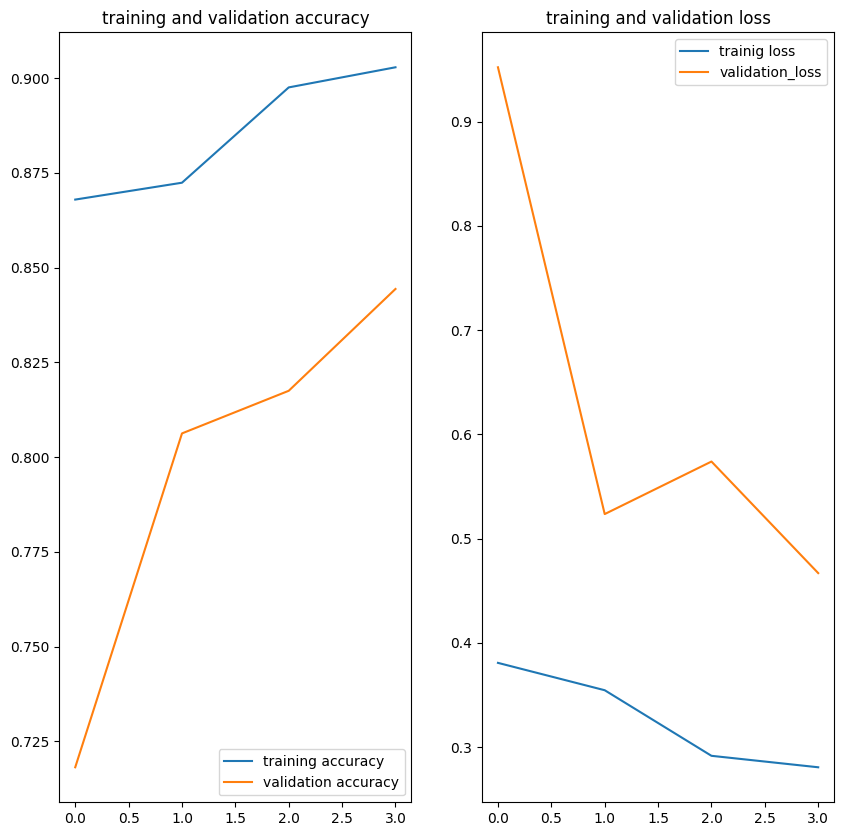

In [293]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label="training accuracy")
plt.plot(range(epochs),val_acc,label="validation accuracy")
plt.legend(loc="lower right")
plt.title("training and validation accuracy")

plt.subplot(1,2,2)   # 1. satır 2. sütunun 2. grafiği
plt.plot(range(epochs),loss,label="trainig loss")
plt.plot(range(epochs),val_loss,label="validation_loss")
plt.legend(loc="upper right")
plt.title("training and validation loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
prediction for the first image
first image actual class is : Tomato_Spider_mites_Two_spotted_spider_mite
first image predicted class is Tomato__Target_Spot


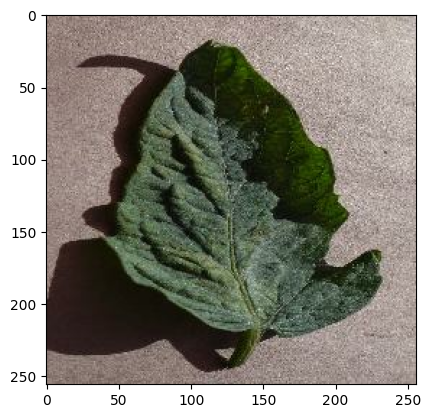

In [297]:
import numpy as np

for image_batch,image_label in df.take(1):    # her calıstıgında imageler değişir cunku shuffle yaparak alıyor .take()
    image=image_batch[0].numpy().astype("uint8")
    label=image_label[0].numpy()

    actual_class=class_names[label]
    predicted=model.predict(image_batch)  # 32 görüntünün tahminini tutuyor.  model.predict(first_image) çalışmaz çünkü model bir batch bekler. bu şekilde girersek (image_size,image_size,channel) şeklinde olur girdileri. first image tek bir görüntü oldugu için.
    print("prediction for the first image")
    plt.imshow(image)
    print("first image actual class is :",actual_class)
    print("first image predicted class is",class_names[np.argmax(predicted[0])])  # 3 değerli çıktı verdi 3 sınıfımız oldugu için bunlardan en yüksek olanı bizim görüntünün sınıfı. argmax ile onu aldık ve class_names listesinden de ismini aldık sınıfın

In [299]:
def predict(model,image):
    img_array=tf.keras.utils.img_to_array(image)
    img_array=tf.expand_dims(img_array,0)  # batch oluşturduk

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    coinfidence=round(100*(np.max(predictions[0])),2)

    return predicted_class,coinfidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


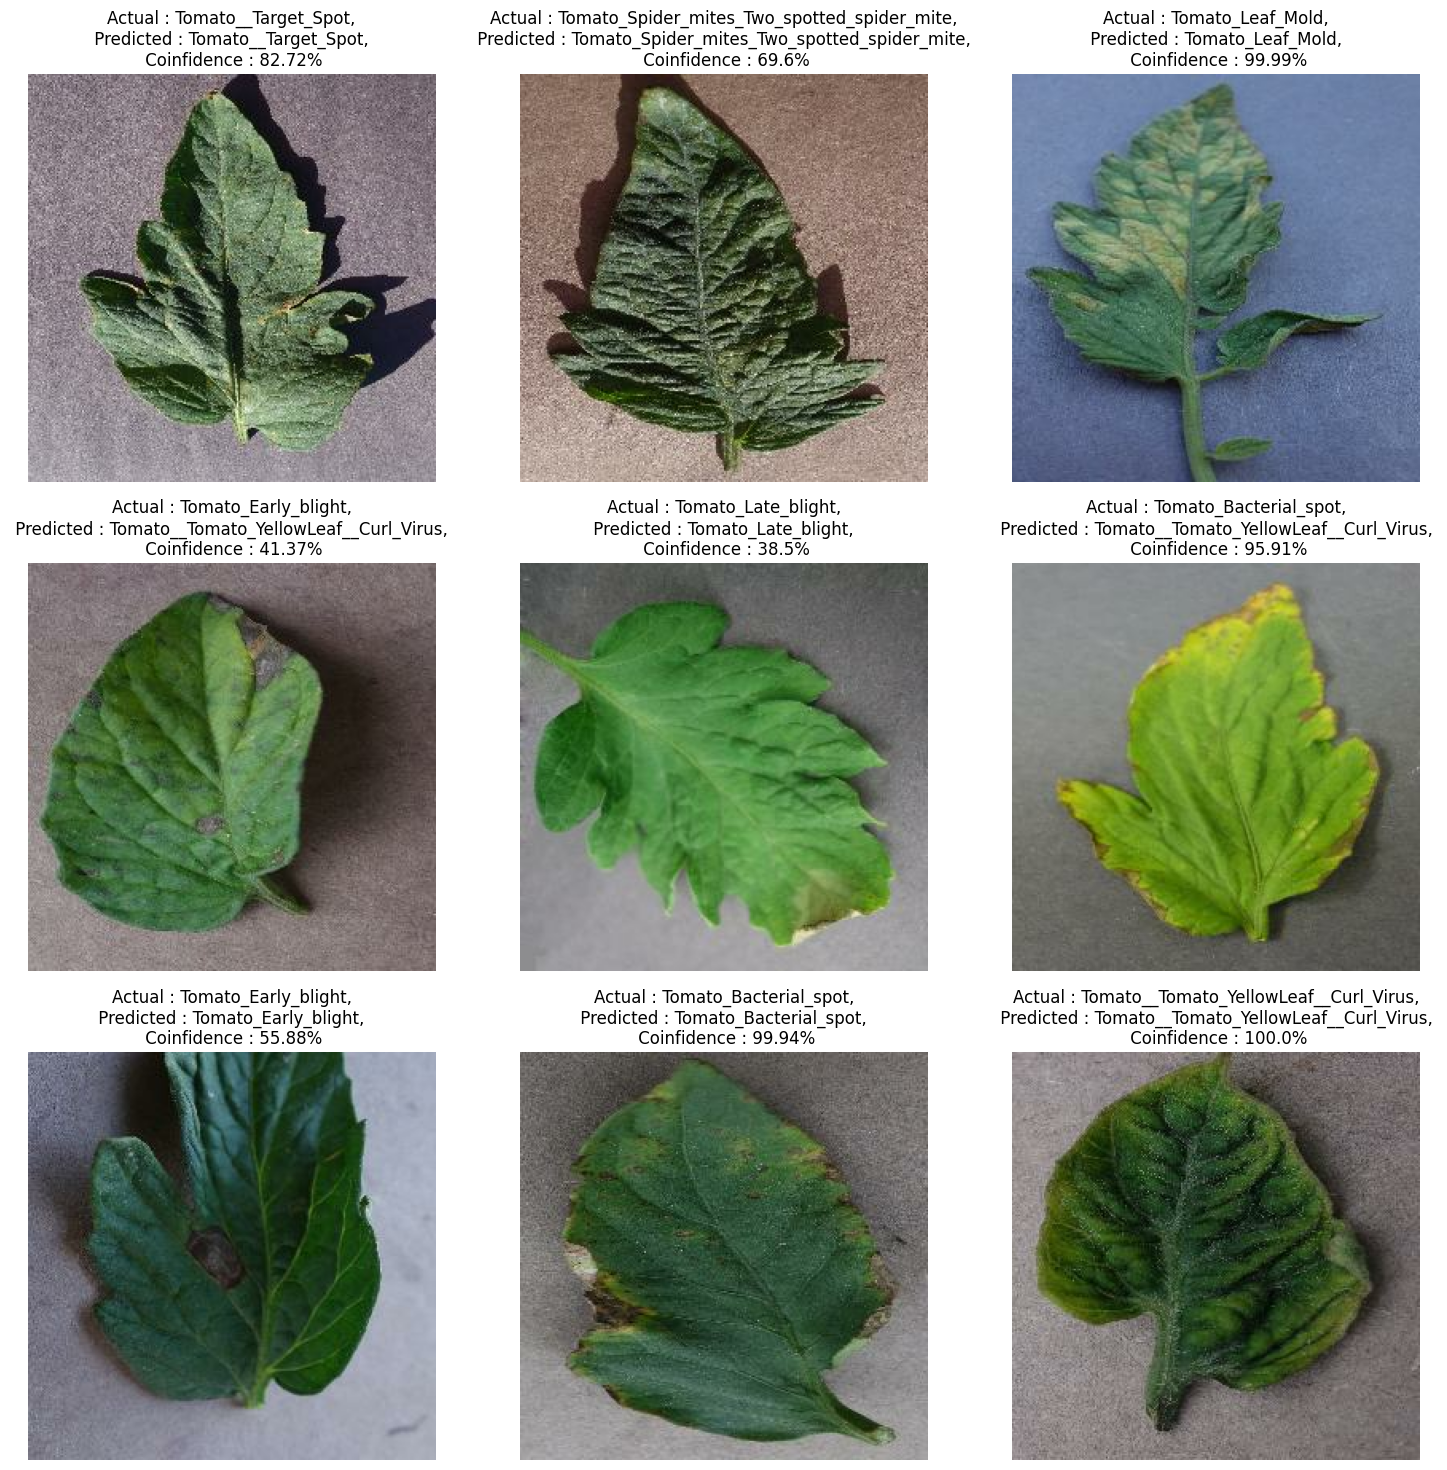

In [307]:
plt.figure(figsize=(18,18))

for images,labels in df.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,coinfidence = predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}, \n Coinfidence : {coinfidence}%")
        plt.axis("off")

In [313]:
import os 
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
# model mimarisi değiştirilip farklı modeller kaydedilebilir.
# her seferinde sonraki versiyon olacak şekilde modeli kaydeder.   modelleri inte çevirdi max sayısını buldu ve bir ekliyor.
model.save(f"../models/{model_version}.keras")